In [1]:
suppressPackageStartupMessages({
    library(GenomicRanges)
    library(GenomicFiles)
    library(rtracklayer)
    library(viridis)
    library(tidyverse)
    library(BRGenomics)
    library(iterators)
    library(foreach)
    library(doParallel)
    library(ggpointdensity)
});
registerDoParallel(11);
source("./CoPRO_Functions.r");
source("~/bin/import_fonts.r");
import_myriad();
theme_set(theme_classic(base_family = "Myriad Pro") +
    theme(
        axis.text = element_text(color="#000000", size=12),
        axis.title = element_text(color="#000000", size=14, face="bold")
    ));

load("../data/newK562_CoPROcalls.Rdata");
#load("../data/Mappable21mers.Rdata");
load("../data/newK562_CoPRO_maxTSB.Rdata");
strand(TREs) = ifelse(TREs$ID5<0, "-", "+");

In [2]:
TSS = TSS[ !seqnames(TSS) %in% c("chrX", "chrM") ];
mTSB = mTSB[ !seqnames(mTSB) %in% c("chrX", "chrM") ];
TREs = TREs[ !seqnames(TREs) %in% c("chrX", "chrM") ];
#mapTSB = mTSB[ mTSB$ID5 %in% MapID5 ];

In [3]:
# order by capped reads to choose maxTSS within a TRE
TSS = TSS[order(TSS$Cap, decreasing=T)];
mTSS = TSS[!duplicated(paste(strand(TSS), TSS$TREID))];
mTSS = mTSS[order(mTSS$TREID, strand(mTSS))];
mTSS = mTSS[ mTSS$TREID %in% mTSS$TREID[duplicated(mTSS$TREID)] ];
mTSS$Pair=NULL;
mTSS$CapR=NULL;
mTSS$TermR=NULL;
mTSS$mTSB=NULL;
#mTSS

In [4]:
fwdTSS = subsetByOverlaps(mTSS, TREs);
revTSS = subsetByOverlaps(mTSS, TREs, invert=T);

# remove fwdTSS facing revTSS
hits = findOverlaps( promoters(fwdTSS, upstream=0, downstream=600), revTSS, ignore.strand=T );
fwdTSS = fwdTSS[-unique(hits@from)];
revTSS = revTSS[-unique(hits@from)];

Warning message:
“Removed 200 rows containing missing values (geom_tile).”
Warning message:
“Removed 200 rows containing missing values (geom_tile).”


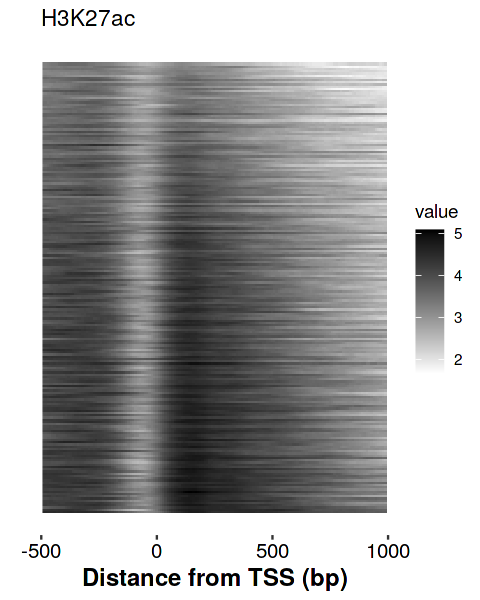

Warning message:
“Removed 200 rows containing missing values (geom_tile).”


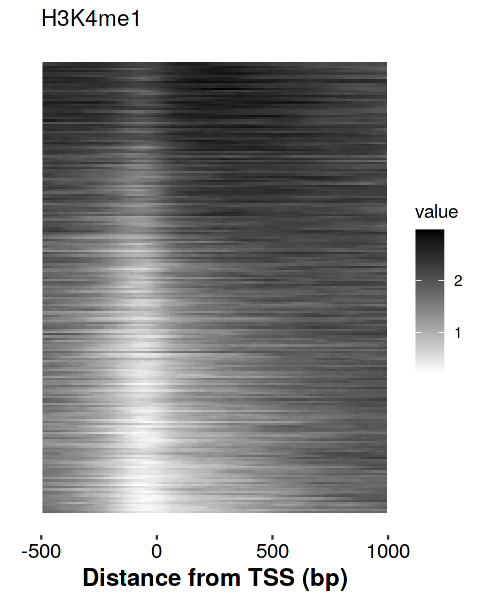

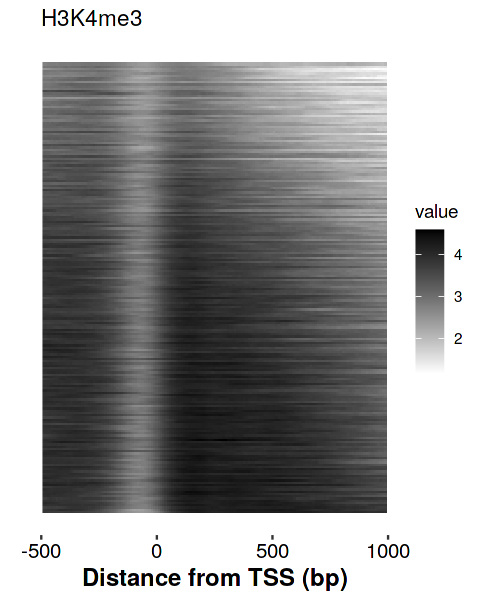

In [5]:
mxTSB = subsetByOverlaps( mTSB, fwdTSS );
mxTSB = mxTSB[order(mxTSB$PsOcc, decreasing=T)];
fnames = list.files('/media/nate/Diatom/Sequencing/ChIP/Encode/bw/', pattern='RoadMap-H3*');
windows = promoters(mxTSB, upstream=500, downstream=1010 );
options(repr.plot.width=4, repr.plot.height=5, jupyter.plot_mimetypes = "image/png");

out = data.frame(pause=10*mxTSB$PsOcc, release=10*mxTSB$C);
for( fn in fnames ) {
    hmark = sub( "RoadMap-", "", fn, fixed=T);
    hmark = sub( ".bw", "", hmark, fixed=T);
    signal = import(paste0('/media/nate/Diatom/Sequencing/ChIP/Encode/bw/', fn));
    signal = getCountsByPositions( signal, windows, FUN='max', binsize=10 );
    out[,hmark] = rowMaxs( signal[,50+(1:30)] )+1;
    signal = LinearHeatmap( na.omit(signal), 200 );
    signal = log2( 1+signal );
    df = reshape2::melt(signal, varnames = c("TSS", "pos"));
    df$TSS = as.integer(factor(df$TSS));
    print(
        ggplot(df, aes(x = (10*as.numeric(pos))-500, y = TSS, fill = value)) +
            geom_tile() + ggtitle(hmark) +
            xlab("Distance from TSS (bp)") + ylab("") +
            scale_fill_gradient(low="white", high="black", space = "Lab",
                na.value = "grey50", guide = "colourbar", aesthetics = "fill")  +
            scale_x_continuous(limits = c(-500, 1000), expand = c(0, 0), breaks = c(-500, 0, 500, 1000)) +
        theme( axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.line = element_line(colour = "white") )
    );
}
out = out[out$pause>0 & out$H3K4me3>0 & out$H3K4me1>0 & out$H3K27ac>0,]

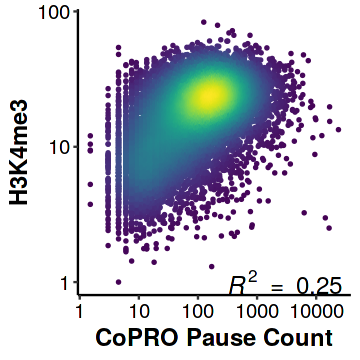

In [6]:
rsq = unname(cor.test( log2(out$pause), log2(out$H3K4me3) )$estimate^2);
rsq = round(rsq, 2);
rsq = substitute(italic(R^2)~"="~rval, list(rval=rsq));
rsq = as.character(as.expression(rsq));

options(repr.plot.width=3, repr.plot.height=3, jupyter.plot_mimetypes = "image/png");
ggplot( out, aes(x=pause, y=H3K4me3) ) +
    geom_pointdensity(size=0.5, show.legend = F) +
    scale_color_viridis() +
    xlab("CoPRO Pause Count") +
    scale_x_continuous(trans="log10") +
    scale_y_continuous(trans="log10") +
    geom_text(aes( 3000, 1, label = rsq ), data=data.frame(), parse=T, col='black', size=5 );

In [19]:
out$psq = log2(out$pause)^2;
rsq = lm( log2(H3K4me3) ~ log2(pause) + psq, data=out );
rsq = summary(rsq);
rsq = round(rsq$adj.r.squared,2);
rsq

[1] 0.29

In [ ]:
rsq = unname(cor.test( log2(out$pause), log2(out$H3K4me3) )$estimate^2);
rsq = round(rsq, 2);
rsq = substitute(italic(R^2)~"="~rval, list(rval=rsq));
rsq = as.character(as.expression(rsq));

options(repr.plot.width=3, repr.plot.height=3, jupyter.plot_mimetypes = "image/png");
ggplot( out, aes(x=pause, y=H3K4me3) ) +
    geom_pointdensity(size=0.5, show.legend = F) +
    scale_color_viridis() +
    xlab("CoPRO Pause Count") +
    scale_x_continuous(trans="log10") +
    scale_y_continuous(trans="log10") +
    geom_text(aes( 3000, 1, label = rsq ), data=data.frame(), parse=T, col='black', size=5 );

In [ ]:
rsq = unname(cor.test( log2(out$pause), log2(out$H3K4me1) )$estimate^2);
rsq = round(rsq, 2);
rsq = substitute(italic(R^2)~"="~rval, list(rval=rsq));
rsq = as.character(as.expression(rsq));

ggplot( out, aes(x=pause, y=H3K4me1) ) +
    geom_pointdensity(size=0.5, show.legend = F) +
    scale_color_viridis() +
    xlab("CoPRO Pause Count") +
    scale_x_continuous(trans="log10") +
    scale_y_continuous(trans="log10") +
    geom_text(aes( 3000, 0.7, label = rsq ), data=data.frame(), parse=T, col='black', size=5 );

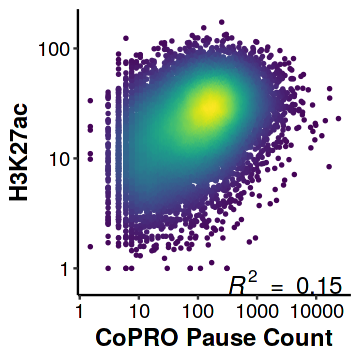

In [15]:
rsq = unname(cor.test( log2(out$pause), log2(out$H3K27ac) )$estimate^2);
rsq = round(rsq, 2);
rsq = substitute(italic(R^2)~"="~rval, list(rval=rsq));
rsq = as.character(as.expression(rsq));

ggplot( out, aes(x=pause, y=H3K27ac) ) +
    geom_pointdensity(size=0.5, show.legend = F) +
    scale_color_viridis() +
    xlab("CoPRO Pause Count") +
    scale_x_continuous(trans="log10") +
    scale_y_continuous(trans="log10") +
    geom_text(aes( 3000, 0.75, label = rsq ), data=data.frame(), parse=T, col='black', size=5 );

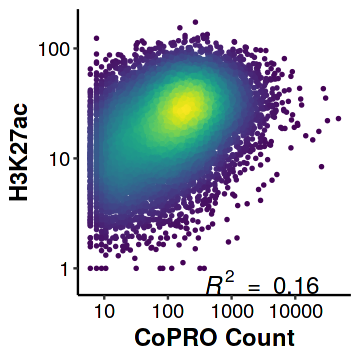

In [16]:
rsq = unname(cor.test( log2(out$release), log2(out$H3K27ac) )$estimate^2);
rsq = round(rsq, 2);
rsq = substitute(italic(R^2)~"="~rval, list(rval=rsq));
rsq = as.character(as.expression(rsq));

ggplot( out, aes(x=release, y=H3K27ac) ) +
    geom_pointdensity(size=0.5, show.legend = F) +
    scale_color_viridis() +
    xlab("CoPRO Count") +
    scale_x_continuous(trans="log10") +
    scale_y_continuous(trans="log10") +
    geom_text(aes( 3000, 0.75, label = rsq ), data=data.frame(), parse=T, col='black', size=5 );